In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
sns.set(font_scale=2)

In [26]:
def parse_d(row, d_names):
    rng = range(row['groups'])
    for i, j in product(rng, rng):
        row[f'd_{i+1}{j+1}'] = row['d'][i,j]
        
    return row[d_names]

def parse_var(row, var_names, var):
    for i in range(row['groups']):
        row[f'{var}_{i+1}'] = row[var].flatten()[i]
    return row[var_names]

def parse_test(path=None):
    
    if path:
        base = pd.read_pickle(specific_file)
    else:
        l = [file_name for file_name in os.listdir() if os.path.splitext(file_name)[1] == '.pickle']

        base = pd.concat([pd.read_pickle(path) for path in l], axis=0)
        base = base[base['l'].apply(lambda x: (x!=0).all())].reset_index(drop=True)
        
        
    for col in ['sol', 'sol_gov']:
        base = pd.concat([base.drop(col, axis=1), pd.json_normalize(base[col]).add_suffix('_' + col)], axis=1)

    for col in ['cost_sol', 'cost_sol_gov']:
        base[col] = base[col].apply(lambda x: x.flatten())
        base[col] = pd.DataFrame(base[col].to_list()).sum(axis=1)


    base['sol_gap'] = base['cost_sol'] - base['cost_sol_gov']

    best_sol_indx = np.argmin(base[['cost_sol', 'cost_sol_gov']].to_numpy(), axis=1)
    base['best_sol'] = np.take(['cost_sol', 'cost_sol_gov'], best_sol_indx)
    
    base['groups'] = base['d'].apply(lambda x: x.shape[0])
    max_groups = base['groups'].max()
    rng = range(1, max_groups+1)
    
    d_names = [f'd_{i}{j}' for i, j in product(rng, rng)]
    base[d_names] = 0
    base[d_names] = base.apply(lambda row: parse_d(row, d_names), axis=1)

    l_names = [f'l_{i}' for i in rng]
    base[l_names] = 0
    base[l_names] = base.apply(lambda row: parse_var(row, l_names, 'l'), axis=1)

    v_names = [f'v_sol_{i}' for i in rng]
    base[v_names] = 0
    base[v_names] = base.apply(lambda row: parse_var(row, v_names, 'v_sol'), axis=1)

    v_names = [f'S_sol_{i}' for i in rng]
    base[v_names] = 0
    base[v_names] = base.apply(lambda row: parse_var(row, v_names, 'S_sol'), axis=1)

    v_names = [f'S_sol_gov_{i}' for i in rng]
    base[v_names] = 0
    base[v_names] = base.apply(lambda row: parse_var(row, v_names, 'S_sol_gov'), axis=1)
    
    return base
        
def rename_cols(df, factor, group_to_compare):
    df = df.copy()

    max_l_to_compare = df['l_1'].max()*factor
    df.query(f'l_{group_to_compare} < {max_l_to_compare}', inplace=True)

    df['best_sol'] = df['best_sol'].str.replace('cost_sol_gov', 'government')
    df['best_sol'] = df['best_sol'].str.replace('cost_sol', 'equilibrium')
    df.rename({'best_sol': 'Lowest Cost', 'l_1': 'Young Cost of Infection', f'l_{group_to_compare}': 'Old Cost of Infection'}, axis=1, inplace=True)
    df['factor'] = (df['Young Cost of Infection']*factor)
    return df

# 2 groups

In [23]:
specific_file = '/Users/danielablin/Documents/GitHub/Thesis/test_run_2023-02-06_129_10000_2.pickle'
base = parse_test(specific_file)

In [24]:
base.groupby(['best_sol', 'msg_sol'])['best_sol'].count()

best_sol      msg_sol       
cost_sol      found solution    1433
cost_sol_gov  found solution    8567
Name: best_sol, dtype: int64

<AxesSubplot:xlabel='Old Cost of Infection', ylabel='Young Cost of Infection'>

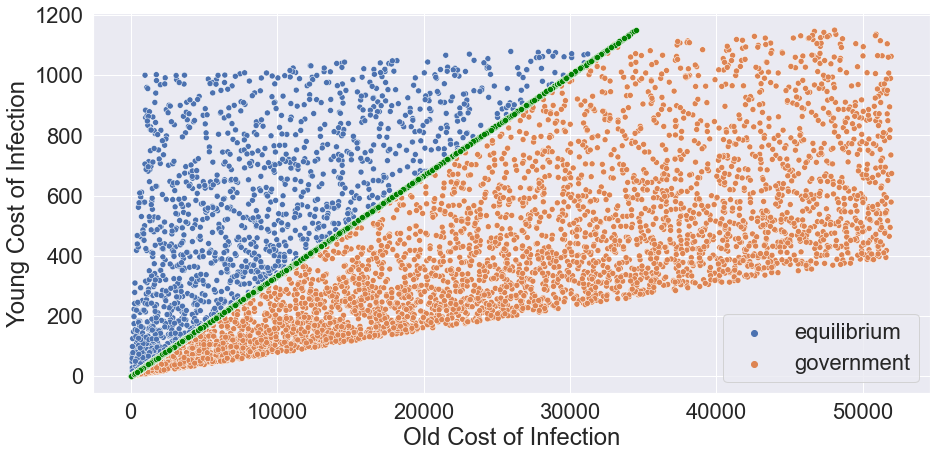

In [27]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)

test = rename_cols(base, 30, 2)

sns.scatterplot(data=test, x='Old Cost of Infection', y='Young Cost of Infection', hue='Lowest Cost')
sns.scatterplot(data=test, x='factor', y='Young Cost of Infection', color='green')

# 3 groups

In [28]:
specific_file = '/Users/danielablin/Documents/GitHub/Thesis/test_run_2023-02-08_129_10000_3.pickle'
base = parse_test(specific_file)

In [29]:
base.groupby('best_sol')['best_sol'].count()

best_sol
cost_sol        1278
cost_sol_gov    8722
Name: best_sol, dtype: int64

<AxesSubplot:xlabel='Old Cost of Infection', ylabel='Young Cost of Infection'>

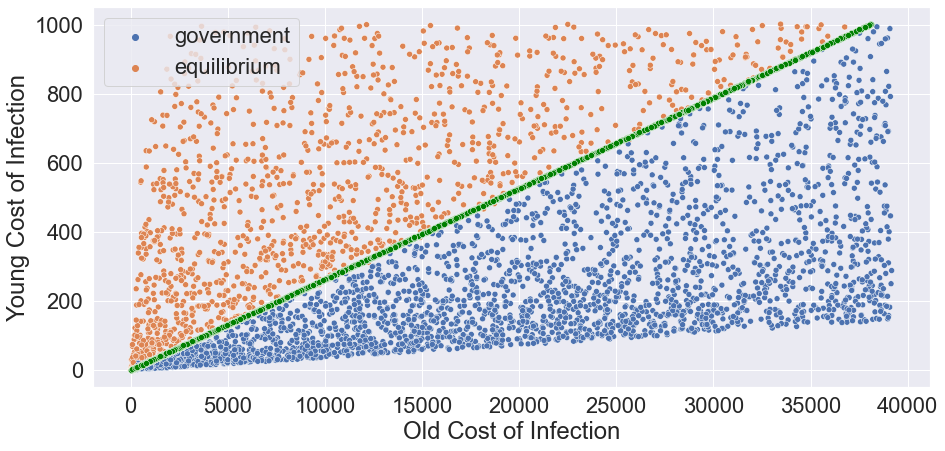

In [35]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)

test = rename_cols(base, 38, 3)

sns.scatterplot(data=test, x='Old Cost of Infection', y='Young Cost of Infection', hue='Lowest Cost')
sns.scatterplot(data=test, x='factor', y='Young Cost of Infection', color='green')

# 4 groups

In [36]:
specific_file = '/Users/danielablin/Documents/GitHub/Thesis/test_run_2023-02-10_129_10000_4.pickle'
base = parse_test(specific_file)

In [37]:
base.groupby('best_sol')['best_sol'].count()

best_sol
cost_sol        1065
cost_sol_gov    8935
Name: best_sol, dtype: int64

<AxesSubplot:xlabel='Old Cost of Infection', ylabel='Young Cost of Infection'>

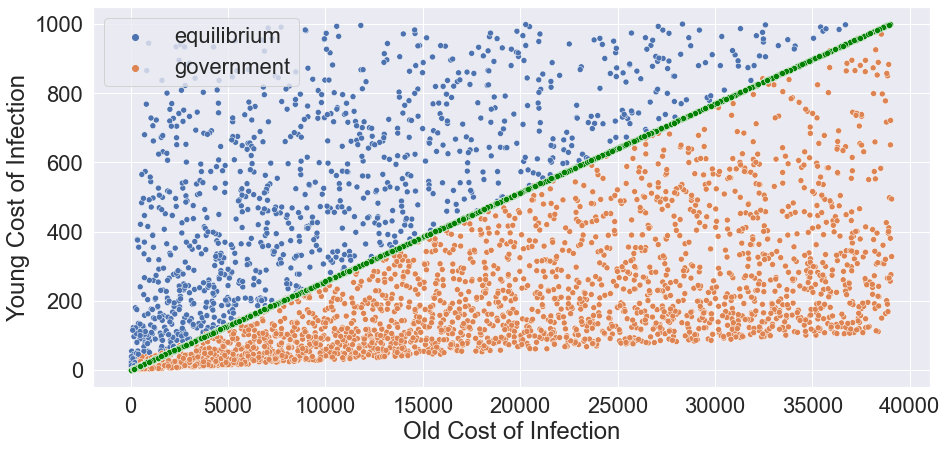

In [39]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(15)

test = rename_cols(base, 39, 4)

sns.scatterplot(data=test, x='Old Cost of Infection', y='Young Cost of Infection', hue='Lowest Cost')
sns.scatterplot(data=test, x='factor', y='Young Cost of Infection', color='green')

# 2 groups moving d

In [119]:
specific_file = '/Users/danielablin/Documents/GitHub/Thesis/test_run_d_2023-01-04_129_20.pickle'
base = parse_test(specific_file)
temp_l = pd.DataFrame(base['l'].to_list())
base['risk rate'] = round(temp_l[1]/temp_l[0], 3)
base['connection rate'] = base['d_12']/(base['d_11'] + base['d_12'])
#base['sol_gap'] = (base['sol_gap']*10).clip(-1,1)
base['POA'] = base['cost_sol'] / base['cost_sol_gov']

In [36]:
base['l'] = base['l'].astype(str)
base.query('pre <= 0.5').groupby(['cat', 'best_sol', 'l'])['cat'].count()

cat     best_sol      l                      
3.826   cost_sol      [0.58740301 2.24741574]    10
        cost_sol_gov  [0.58740301 2.24741574]    10
3.943   cost_sol      [0.54077003 2.13244006]    10
        cost_sol_gov  [0.54077003 2.13244006]    10
4.391   cost_sol      [0.89672104 3.93784997]     9
        cost_sol_gov  [0.89672104 3.93784997]    11
4.821   cost_sol      [0.83282829 4.01479611]     9
        cost_sol_gov  [0.83282829 4.01479611]    11
4.822   cost_sol      [0.24220057 1.16780179]    10
        cost_sol_gov  [0.24220057 1.16780179]    10
5.152   cost_sol      [0.99375366 5.11949424]     9
        cost_sol_gov  [0.99375366 5.11949424]    11
5.174   cost_sol      [0.75637438 3.91358075]     9
        cost_sol_gov  [0.75637438 3.91358075]    11
5.231   cost_sol      [0.5057221  2.64542864]     9
        cost_sol_gov  [0.5057221  2.64542864]    11
5.681   cost_sol      [0.75080045 4.26531944]     8
        cost_sol_gov  [0.75080045 4.26531944]    12
5.882   cost_sol  

In [33]:
base.query('pre > 0.1 and pre < 0.2')

,T,I0,d,l,contagiousness,time,v_sol,v_der_sol,cost_sol,msg_sol,S_sol,test_results.solution_sol,v_sol_gov,v_der_sol_gov,cost_sol_gov,msg_sol_gov,S_sol_gov,test_results.solution_sol_gov,sol_gap,best_sol,groups,d_11,d_12,d_21,d_22,l_1,l_2,v_sol_1,v_sol_2,cat,pre
7,547,0.0001,"[[6.125692978512003, 0.6832255861433334], [2.3...",[0.24220057 1.16780179],1,63.468994,"[[0.17408874870749858], [0.21409092443541514]]","[[6.890132908665692e-11], [-3.5057752256761887...",9.477230,found solution,"[[0.662942208075677], [0.7416944044438675]]",True,0.173902,"[[-9.385539109761776], [9.385539109762078]]",9.906234,found solution,"[[0.7320909404251318], [0.8527819853030165]]",True,-1.000000,cost_sol,2,6.125693,0.683226,2.382214,1.756866,0.242201,1.167802,0.174089,0.214091,4.822,0.100343
8,547,0.0001,"[[5.785376701928003, 0.7808292413066668], [2.7...",[0.24220057 1.16780179],1,63.540497,"[[0.17750882498430245], [0.20705584701475424]]","[[4.7492676458205096e-11], [-2.290157397055736...",9.568558,found solution,"[[0.6643534012306658], [0.7332369808582108]]",True,0.175680,"[[-12.408217842017656], [12.408217842017756]]",9.793340,found solution,"[[0.7552146633266218], [0.8456475543853783]]",True,-1.000000,cost_sol,2,5.785377,0.780829,2.722530,1.659262,0.242201,1.167802,0.177509,0.207056,4.822,0.118916
9,547,0.0001,"[[5.445060425344003, 0.8784328964700001], [3.0...",[0.24220057 1.16780179],1,58.723684,"[[0.18124118763340938], [0.1999525299190344]]","[[-1.808402316783031e-10], [4.4275694222051243...",9.661968,found solution,"[[0.6660548054728161], [0.725917794658339]]",True,0.177411,"[[-14.684633760147236], [14.684633760147264]]",9.684335,found solution,"[[0.7758731384940636], [0.8402931301807667]]",True,-0.223666,cost_sol,2,5.445060,0.878433,3.062846,1.561658,0.242201,1.167802,0.181241,0.199953,4.822,0.138916
10,547,0.0001,"[[5.104744148760004, 0.9760365516333335], [3.4...",[0.24220057 1.16780179],1,56.294588,"[[0.1853393398730452], [0.19278892567671008]]","[[-3.085744992858963e-10], [3.716351670846052e...",9.759377,found solution,"[[0.6680497942779638], [0.719470170526326]]",True,0.179090,"[[-16.38291610895805], [16.382916108958003]]",9.579727,found solution,"[[0.7940753777287857], [0.8362674290336681]]",True,1.000000,cost_sol_gov,2,5.104744,0.976037,3.403163,1.464055,0.242201,1.167802,0.185339,0.192789,4.822,0.160512
11,547,0.0001,"[[4.764427872176004, 1.0736402067966668], [3.7...",[0.24220057 1.16780179],1,55.582436,"[[0.1898665232860692], [0.1855740511225309]]","[[-5.951932280368055e-10], [7.038956084670644e...",9.862609,found solution,"[[0.6703485837607492], [0.71370088498491]]",True,0.180711,"[[-17.642415557384176], [17.642415557384293]]",9.480020,found solution,"[[0.8099764996784089], [0.8332328156351827]]",True,1.000000,cost_sol_gov,2,4.764428,1.073640,3.743479,1.366451,0.242201,1.167802,0.189867,0.185574,4.822,0.183903
32,547,0.0001,"[[6.125692978512003, 0.6832255861433334], [2.3...",[0.72029587 4.41951311],1,55.076069,"[[0.16714060692564053], [0.19307379891103912]]","[[-7.624052500432299e-10], [1.2522569647899218...",14.432973,found solution,"[[0.8093233517678616], [0.8721116449610025]]",True,0.162988,"[[-17.13655573405118], [17.136555734051328]]",14.559854,found solution,"[[0.8801080299580455], [0.937063800139987]]",True,-1.000000,cost_sol,2,6.125693,0.683226,2.382214,1.756866,0.720296,4.419513,0.167141,0.193074,6.136,0.100343
33,547,0.0001,"[[5.785376701928003, 0.7808292413066668], [2.7...",[0.72029587 4.41951311],1,58.563681,"[[0.1705750987250444], [0.18631085013160087]]","[[-1.3137935184204252e-10], [3.447517826771218...",14.567767,found solution,"[[0.8105721193221269], [0.8666133200895454]]",True,0.164474,"[[-19.378213141696722], [19.37821314169681]]",14.454926,found solution,"[[0.8924240129503236], [0.9344230406181007]]",True,1.000000,cost_sol_gov,2,5.785377,0.780829,2.722530,1.659262,0.720296,4.419513,0.170575,0.186311,6.136,0.118916
34,547,0.0001,"[[5.445060425344003, 0.8784328964700001], [3.0...",[0.72029587 4.41951311],1,56.103253,"[[0

In [68]:
risks_to_show = [3.943, 7.010, 11.079, 20.820]

In [71]:
base[base['risk rate'].isin(risks_to_show)]

,T,I0,d,l,contagiousness,time,v_sol,v_der_sol,cost_sol,msg_sol,S_sol,test_results.solution_sol,v_sol_gov,v_der_sol_gov,cost_sol_gov,msg_sol_gov,S_sol_gov,test_results.solution_sol_gov,sol_gap,best_sol,groups,d_11,d_12,d_21,d_22,l_1,l_2,v_sol_1,v_sol_2,S_sol_1,S_sol_2,S_sol_gov_1,S_sol_gov_2,risk rate,pre,POA
175,547,0.0001,"[[8.507906914600001, 0.0], [0.0, 2.44009137908...","[0.08096976914105891, 1.6857770445419205]",1,46.550400,"[[0.16145216685492497], [0.2556677990645222]]","[[-6.394884621840902e-14], [8.645173465993139e...",8.801143,found solution,"[[0.49828776143552717], [0.9291176670807101]]",True,0.164932,"[[35.580341283916475], [-35.580341283916255]]",10.655347,found solution,"[[0.3991984609812791], [0.9984041502706783]]",True,-1.854204,cost_sol,2,8.507907,0.000000,0.000000,2.440091,0.080970,1.685777,0.161452,0.255668,0.498288,0.929118,0.399198,0.998404,20.820,0.000000,0.825984
176,547,0.0001,"[[8.167590638016001, 0.09760365516333334], [0....","[0.08096976914105891, 1.6857770445419205]",1,57.584053,"[[0.16418489618639304], [0.24279891337159654]]","[[2.8492763703980017e-12], [-1.459845577755913...",9.233409,found solution,"[[0.49846774670313176], [0.8577612069006698]]",True,0.166732,"[[18.849938677011806], [-18.849938677011984]]",10.624625,found solution,"[[0.437989120850349], [0.9484986909833399]]",True,-1.391217,cost_sol,2,8.167591,0.097604,0.340316,2.342488,0.080970,1.685777,0.164185,0.242799,0.498468,0.857761,0.437989,0.948499,20.820,0.011809,0.869057
177,547,0.0001,"[[7.827274361432002, 0.1952073103266667], [0.6...","[0.08096976914105891, 1.6857770445419205]",1,62.397703,"[[0.16701932030081523], [0.23046583824344588]]","[[3.524291969370097e-12], [-9.790603883175208e...",9.592647,found solution,"[[0.49956288098831064], [0.8139766881988784]]",True,0.168111,"[[3.5715634060729826], [-3.571563406073043]]",10.599910,found solution,"[[0.48928802738324173], [0.9116065817875055]]",True,-1.007263,cost_sol,2,7.827274,0.195207,0.680633,2.244884,0.080970,1.685777,0.167019,0.230466,0.499563,0.813977,0.489288,0.911607,20.820,0.024333,0.904974
178,547,0.0001,"[[7.486958084848002, 0.29281096549], [1.020948...","[0.08096976914105891, 1.6857770445419205]",1,63.082694,"[[0.1700024399546973], [0.21910438361335785]]","[[5.9117155615240335e-12], [-1.116866599204513...",9.903606,found solution,"[[0.5010977275476152], [0.7835574233517074]]",True,0.169168,"[[-8.106320595785704], [8.106320595786066]]",10.569334,found solution,"[[0.5483495163246689], [0.8877329978299526]]",True,-0.665728,cost_sol,2,7.486958,0.292811,1.020949,2.147280,0.080970,1.685777,0.170002,0.219104,0.501098,0.783557,0.548350,0.887733,20.820,0.037637,0.937013
179,547,0.0001,"[[7.146641808264002, 0.3904146206533334], [1.3...","[0.08096976914105891, 1.6857770445419205]",1,63.643281,"[[0.17316936012714348], [0.20859397874716268]]","[[1.234212732015294e-11], [-7.100631194134621e...",10.184694,found solution,"[[0.5029152827686213], [0.7605851587474635]]",True,0.170116,"[[-15.819425923381804], [15.819425923381871]]",10.525463,found solution,"[[0.6069702914436216], [0.8736303581087155]]",True,-0.340769,cost_sol,2,7.146642,0.390415,1.361265,2.049677,0.080970,1.685777,0.173169,0.208594,0.502915,0.760585,0.606970,0.873630,20.820,0.051799,0.967624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,547,0.0001,"[[1.701581382920003, 1.952073103266666], [6.80...","[1.1998641350930765, 7.057990490390145]",1,60.951189,"[[0.257996493867095], [0.10544182571240292]]","[[-9.682157298129823e-10], [4.5787373892380856...",20.422642,found solution,"[[0.8884712461219493], [0.8768723427595078]]",True,0.173905,"[[-26.089864442413425], [26.08986444241353]]",17.006240,found solution,"[[0.9661456200483871], [0.9468581708122211]]",True,3.416403,cost_sol_gov,2,1.701581,1.952073,6.806326,0.488018,1.199864,7.057990,0.257996,0.105442,0.888471,0.876872,0.966146,0.946858,5.882,0.534280,1.200891
471,547,0.0001,"[

In [76]:
base['risk rate'].unique()

array([ 4.822,  6.136,  5.152, 13.51 ,  5.948,  4.821,  5.681, 20.82 ,
        3.943,  7.01 ,  5.174,  6.556, 11.079,  5.231,  6.613, 13.635,
        4.391,  3.826,  5.882,  6.687])

/var/folders/xq/smdsq3l138q1rrzfcbmdr9w80000gn/T/ipykernel_1097/4199465012.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['risk rate'] = round(test['risk rate'])
/var/folders/xq/smdsq3l138q1rrzfcbmdr9w80000gn/T/ipykernel_1097/4199465012.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks_labels, fontsize=18)


<AxesSubplot:xlabel='connection rate', ylabel='POA'>

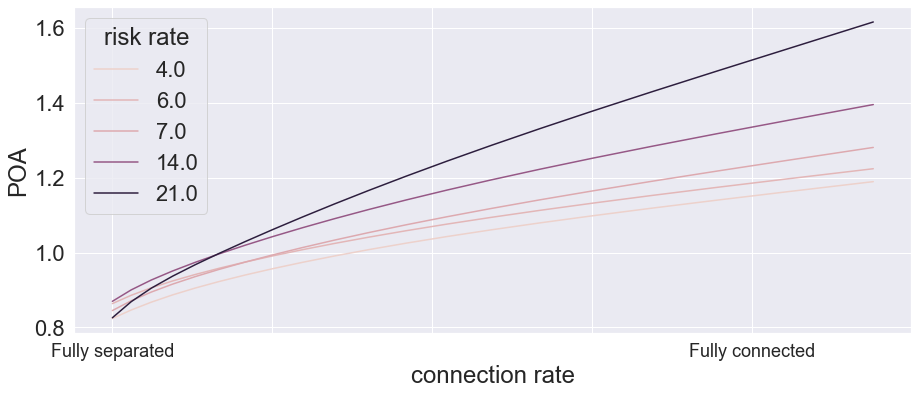

In [121]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(15)
risks_to_show = [3.943, 6.136, 7.010, 13.635, 20.820]
x_ticks_labels = ['', 'Fully separated', '', '', '', 'Fully connected']

test = base[base['risk rate'].isin(risks_to_show) & (base['connection rate'] <= 0.5)]
test['risk rate'] = round(test['risk rate'])

ax.set_xticklabels(x_ticks_labels, fontsize=18)

sns.lineplot(data=test, x='connection rate', y='POA', hue='risk rate')

In [37]:
base.query('cat==7.010')

,T,I0,d,l,contagiousness,time,v_sol,v_der_sol,cost_sol,msg_sol,S_sol,test_results.solution_sol,v_sol_gov,v_der_sol_gov,cost_sol_gov,msg_sol_gov,S_sol_gov,test_results.solution_sol_gov,sol_gap,best_sol,groups,d_11,d_12,d_21,d_22,l_1,l_2,v_sol_1,v_sol_2,cat,pre
225,547,0.0001,"[[8.507906914600001, 0.0], [0.0, 2.44009137908...",[0.43599443 3.05622072],1,46.496941,"[[0.15163285364754348], [0.24666814293319764]]","[[-8.526512829121202e-14], [5.263522950826882e...",11.189046,found solution,"[[0.746139505110526], [0.9539091206651868]]",True,0.155916,"[[39.904738307878375], [-39.904738307878304]]",13.238578,found solution,"[[0.6487906995272598], [0.998810247296095]]",True,-1.000000,cost_sol,2,8.507907,0.000000,0.000000,2.440091,0.435994,3.056221,0.151633,0.246668,7.01,0.000000
226,547,0.0001,"[[8.167590638016001, 0.09760365516333334], [0....",[0.43599443 3.05622072],1,54.296073,"[[0.15409678028421922], [0.23920211131521596]]","[[1.0444978215673473e-11], [-3.604732512485498...",11.462705,found solution,"[[0.7452591085300013], [0.9195453433870616]]",True,0.157643,"[[25.41932483522354], [-25.41932483522366]]",13.154749,found solution,"[[0.6795211856678789], [0.976004559893745]]",True,-1.000000,cost_sol,2,8.167591,0.097604,0.340316,2.342488,0.435994,3.056221,0.154097,0.239202,7.01,0.011809
227,547,0.0001,"[[7.827274361432002, 0.1952073103266667], [0.6...",[0.43599443 3.05622072],1,59.276480,"[[0.15659641184948378], [0.23160519856663486]]","[[1.6413537196058314e-12], [-3.104503321083029...",11.692739,found solution,"[[0.7450928127290279], [0.8949681940023798]]",True,0.159231,"[[12.926078955769931], [-12.926078955769977]]",13.070656,found solution,"[[0.7119598240256251], [0.9577642175163105]]",True,-1.000000,cost_sol,2,7.827274,0.195207,0.680633,2.244884,0.435994,3.056221,0.156596,0.231605,7.01,0.024333
228,547,0.0001,"[[7.486958084848002, 0.29281096549], [1.020948...",[0.43599443 3.05622072],1,61.376605,"[[0.1591819414379148], [0.22407787323600223]]","[[9.833911462919787e-12], [-1.301742713621934e...",11.890214,found solution,"[[0.7453848038708832], [0.8765855385018012]]",True,0.160728,"[[2.8689321083776846], [-2.868932108377777]]",12.983460,found solution,"[[0.7438868616829304], [0.9438401759361233]]",True,-1.000000,cost_sol,2,7.486958,0.292811,1.020949,2.147280,0.435994,3.056221,0.159182,0.224078,7.01,0.037637
229,547,0.0001,"[[7.146641808264002, 0.3904146206533334], [1.3...",[0.43599443 3.05622072],1,62.021276,"[[0.1618926524588424], [0.21666158149857365]]","[[1.525535253676935e-11], [-1.4657217661806499...",12.064823,found solution,"[[0.7460064715371284], [0.8622817618635314]]",True,0.162186,"[[-4.815363021181042], [4.815363021181213]]",12.891759,found solution,"[[0.7734853672493803], [0.9335018611282047]]",True,-1.000000,cost_sol,2,7.146642,0.390415,1.361265,2.049677,0.435994,3.056221,0.161893,0.216662,7.01,0.051799
230,547,0.0001,"[[6.806325531680002, 0.48801827581666674], [1....",[0.43599443 3.05622072],1,59.457081,"[[0.1647643918230117], [0.20933873654219828]]","[[8.72546479513403e-12], [-5.806590763768327e-...",12.224040,found solution,"[[0.7468986386607308], [0.8507945305834156]]",True,0.163645,"[[-10.49852820744115], [10.498528207441147]]",12.795538,found solution,"[[0.799770946463956], [0.9258928736899675]]",True,-1.000000,cost_sol,2,6.806326,0.488018,1.701581,1.952073,0.435994,3.056221,0.164764,0.209339,7.01,0.066904
231,547,0.0001,"[[6.466009255096003, 0.58562193098], [2.041897...",[0.43599443 3.05622072],1,56.894582,"[[0.16783301759369526], [0.20208327374119286]]","[[4.0387249100604095e-11], [-2.654104491739417...",12.373518,found solution,"[[0.7480353293299942], [0.8413328626010746]]",True,0.165122,"[[-14.629773697378198], [14.629773697378369]]",12.695729,found solution,"[[0.8224979527702532], [0.9202693793263242]]",True,-1.000000,cost_sol,2,6.466009,0.585622,2.041898,1.854469,0.435994,3.056221,0.167833,0.202083,7.01,0.083048
232,547,0.0001,"[[6.125692978512003, 0.6832255861433334], [2.3...",[0.43599443 3.05622072],1,55.594